# Réseau de neurones pour la classification avec Pytorch

## Les imports

In [21]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import torch
from torch import nn

from my_helper_functions import accuracy_fn, plot_decision_boundary


## Constantes

In [22]:
RANDOM_STATE = 20
NBR_INPUTS = 2
NBR_OUTPUTS = 4

## Create dataset

In [23]:
x, y = make_blobs(n_samples=1000, n_features=NBR_INPUTS, centers=NBR_OUTPUTS, cluster_std=1.5, random_state=RANDOM_STATE)
print(f"x shape : {x.shape}")
print(f"y shape : {y.shape}")

x shape : (1000, 2)
y shape : (1000,)


In [24]:
x[:5], y[:5]

(array([[ 1.15232915,  6.10745464],
        [-8.69380102,  5.55720101],
        [ 0.23024192,  8.66269151],
        [ 8.18223886,  4.97312766],
        [-7.7675401 ,  2.68558928]]),
 array([0, 2, 0, 1, 2]))

In [25]:
x.dtype, y.dtype

(dtype('float64'), dtype('int32'))

## Split data to train and test data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train :")
print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print("Test :")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

Train :
x_train shape : (800, 2)
y_train shape : (800,)
Test :
x_test shape : (200, 2)
y_test shape : (200,)


## Visualise data

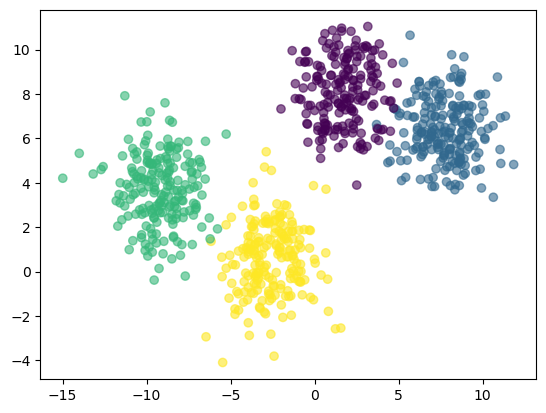

In [27]:
plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.6)
plt.show()

## Adapt data to PyTorch

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
type(x_train)

numpy.ndarray

In [30]:
# Train
x_train = torch.from_numpy(x_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.long).to(device)
# Test
x_test = torch.from_numpy(x_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.long).to(device)
x_train[:5], y_test[:5]

(tensor([[ -3.3588,  -0.3135],
         [-13.1777,   4.3974],
         [ -7.8273,   2.4314],
         [ -8.6589,   2.9140],
         [ -8.6895,   2.4157]], device='cuda:0'),
 tensor([2, 0, 2, 3, 3], device='cuda:0'))

In [31]:
type(x_train), type(y_train)

(torch.Tensor, torch.Tensor)

## Create Model

In [32]:
class MultiClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NBR_INPUTS, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, NBR_OUTPUTS)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [33]:
model = MultiClassificationModel().to(device)
model

MultiClassificationModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

## Loss and Optimizer

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() ,lr=0.01)

## Train

In [35]:
logits = model(x_train)
logits[:5]

tensor([[ 0.1067, -0.2413,  0.2111, -0.1360],
        [ 0.0021, -0.1374,  0.5347,  0.4444],
        [ 0.0534, -0.2014,  0.3584,  0.1169],
        [ 0.0385, -0.1804,  0.3945,  0.1749],
        [ 0.0622, -0.2072,  0.3734,  0.1581]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [36]:
epochs = 150
train_loss_array = []
train_accuracy_array = []
test_loss_array = []
test_accuracy_array = []
softmax = nn.Softmax(dim=1)

for epoch in range(epochs):
    model.train()
    train_logits = model(x_train)
    # Calculate loss
    train_loss = loss_fn(train_logits, y_train)
    train_loss_array.append(train_loss.detach().cpu().numpy())
    # Calculate accuracy
    train_log_proba = softmax(train_logits)
    y_train_pred = torch.argmax(train_log_proba, dim=1)
    train_accuracy = accuracy_fn(y_pred=y_train_pred, y_true=y_train)
    train_accuracy_array.append(train_accuracy)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test)
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_loss_array.append(test_loss.detach().cpu().numpy())
        # Calculate accuracy
        test_log_proba = softmax(test_logits)
        y_test_pred = torch.argmax(test_log_proba, dim=1)
        test_accuracy = accuracy_fn(y_pred=y_test_pred, y_true=y_test)
        test_accuracy_array.append(test_accuracy)

    if epoch % 10 == 0:
        print(f"epoch {epoch} : train loss -> {train_loss} - train accuracy -> {train_accuracy} % | test loss -> {test_loss} - test accuracy -> {test_accuracy} %")

epoch 0 : train loss -> 1.4750144481658936 - train accuracy -> 26.375 % | test loss -> 1.3704577684402466 - test accuracy -> 33.0 %
epoch 10 : train loss -> 0.7374548316001892 - train accuracy -> 77.0 % | test loss -> 0.6631106734275818 - test accuracy -> 80.5 %
epoch 20 : train loss -> 0.33521130681037903 - train accuracy -> 85.125 % | test loss -> 0.3136303126811981 - test accuracy -> 91.0 %
epoch 30 : train loss -> 0.19968898594379425 - train accuracy -> 94.375 % | test loss -> 0.1875017136335373 - test accuracy -> 94.0 %
epoch 40 : train loss -> 0.12072742730379105 - train accuracy -> 97.75 % | test loss -> 0.12466152012348175 - test accuracy -> 98.0 %
epoch 50 : train loss -> 0.07489695399999619 - train accuracy -> 98.625 % | test loss -> 0.0838223546743393 - test accuracy -> 98.5 %
epoch 60 : train loss -> 0.05241376906633377 - train accuracy -> 98.375 % | test loss -> 0.06423294544219971 - test accuracy -> 99.0 %
epoch 70 : train loss -> 0.041750602424144745 - train accuracy -> 

In [37]:
print(f"epoch {epoch} : train loss -> {train_loss} - train accuracy -> {train_accuracy} % | test loss -> {test_loss} - test accuracy -> {test_accuracy} %")

epoch 149 : train loss -> 0.026204630732536316 - train accuracy -> 99.0 % | test loss -> 0.04657408222556114 - test accuracy -> 99.0 %


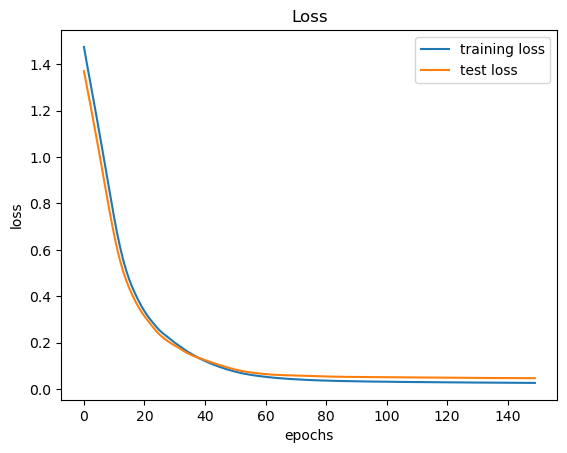

In [38]:
plt.figure()
plt.title("Loss")
plt.plot(range(epochs), train_loss_array, label="training loss")
plt.plot(range(epochs), test_loss_array, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


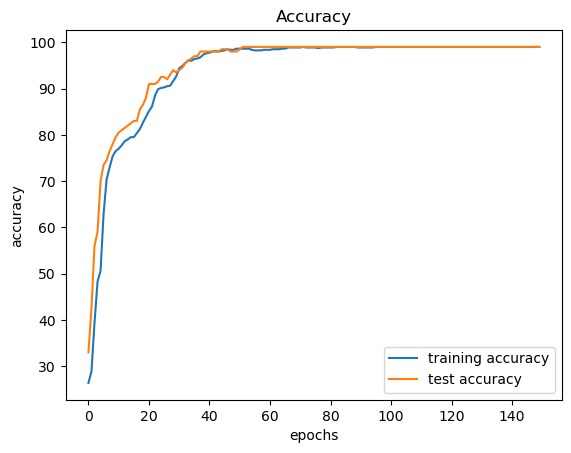

In [39]:
plt.figure()
plt.title("Accuracy")
plt.plot(range(epochs), train_accuracy_array, label="training accuracy")
plt.plot(range(epochs), test_accuracy_array, label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

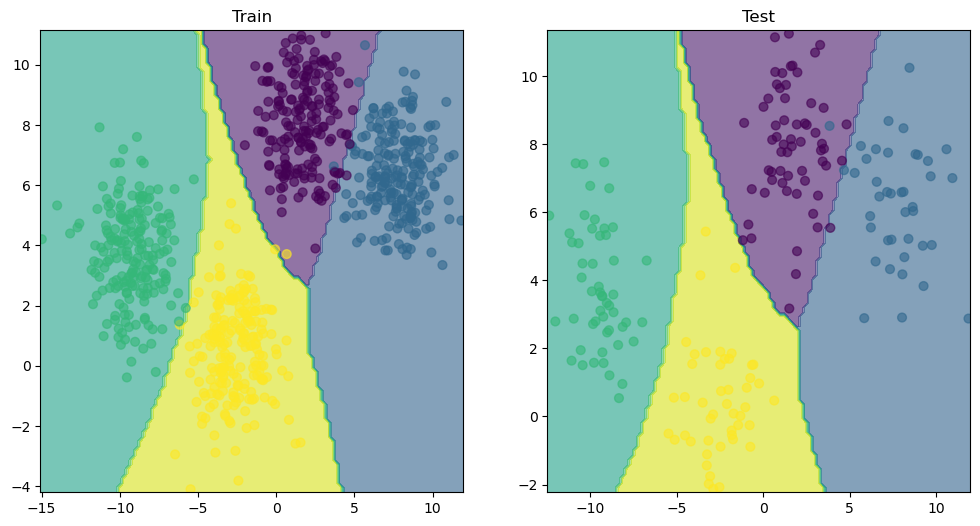

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)